In [1]:
#add environment to PYTHONPATH
import sys
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical, Normal
import numpy as np

import gymnasium as gym
from tqdm import tqdm
from collections import deque
import continuouscartpole_env

In [2]:
#discount factor for future utilities
DISCOUNT_FACTOR = 0.99

#number of episodes to run
NUM_EPISODES = 1000

#max steps per episode
MAX_STEPS = 500

#score needed for environement to be considered solved
SOLVED_SCORE = 195

#device to run model on 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
#Using a neural network to learn our policy parameters for one continuous action
class PolicyNetwork(nn.Module):
    
    #Takes in observations and outputs actions mu and sigma
    def __init__(self, observation_space):
        super(PolicyNetwork, self).__init__()
        self.input_layer = nn.Linear(observation_space, 128)
        self.output_layer = nn.Linear(128, 2)
    
    #forward pass
    def forward(self, x):
        #input states
        x = self.input_layer(x)
        
        x = F.relu(x)
        
        #actions
        action_parameters = self.output_layer(x)
        
        return action_parameters

In [4]:
def select_action(network, state):
    ''' Selects an action given state
    Args:
    - network (Pytorch Model): neural network used in forward pass
    - state (Array): environment state
    
    Return:
    - action.item() (float): continuous action
    - log_action (float): log of probability density of action
    
    '''
    
    #create state tensor
    state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
    state_tensor.required_grad = True
    
    #forward pass through network
    action_parameters = network(state_tensor)
    
    #get mean and std, get normal distribution
    mu, sigma = action_parameters[:, :1], torch.exp(action_parameters[:, 1:])
    m = Normal(mu[:, 0], sigma[:, 0])

    #sample action, get log probability
    action = m.sample()
    log_action = m.log_prob(action)

    return action.item(), log_action, mu[:, 0].item(), sigma[:, 0].item()

In [5]:
def process_rewards(rewards):
    ''' Converts our rewards history into cumulative discounted rewards
    Args:
    - rewards (Array): array of rewards 
    
    Returns:
    - G (Array): array of cumulative discounted rewards
    '''
    #Calculate Gt (cumulative discounted rewards)
    G = []
    
    #track cumulative reward
    total_r = 0
    
    #iterate rewards from Gt to G0
    for r in reversed(rewards):
        
        #Base case: G(T) = r(T)
        #Recursive: G(t) = r(t) + G(t+1)*DISCOUNT
        total_r = r + total_r * DISCOUNT_FACTOR
        
        #add to front of G
        G.insert(0, total_r)
    
    #whitening rewards
    G = torch.tensor(G).to(DEVICE)
    G = (G - G.mean())/G.std()
    
    return G

In [6]:
#Make environment
env = gym.make('ContinuousCartPole-v0')

#Init network
network = PolicyNetwork(env.observation_space.shape[0]).to(DEVICE)

#Init optimizer
optimizer = optim.Adam(network.parameters(), lr=0.001)

/home/a.shankar/Documents/Work/ContinuousRL/.env/lib/python3.10/site-packages/gymnasium/envs/registration.py:485: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(
/home/a.shankar/Documents/Work/ContinuousRL/.env/lib/python3.10/site-packages/gymnasium/spaces/box.py:235: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/home/a.shankar/Documents/Work/ContinuousRL/.env/lib/python3.10/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [7]:
#track scores
scores = []

#track recent scores
recent_scores = deque(maxlen=100)

#track mu and sigma
means = []
stds = []

#iterate through episodes
for episode in tqdm(range(NUM_EPISODES)):
    
    #reset environment, initiable variables
    state, _ = env.reset()
    rewards = []
    log_actions = []
    score = 0
    
    #generate episode
    for step in range(MAX_STEPS):
        #env.render()
        
        #select action, clip action to be [-1, 1]
        action, la, mu, sigma = select_action(network, state)
        #action = min(max(-1, action), 1)
        
        #track distribution parameters
        means.append(mu)
        stds.append(sigma)
        
        #execute action
        new_state, reward, done, _, _ = env.step(action)
        
        #track episode score
        score += reward
        
        #store reward and log probability
        rewards.append(reward)
        log_actions.append(la)
        
        #end episode
        if done:
            break
        
        #move into new state
        state = new_state
    
    #append score
    scores.append(score)
    recent_scores.append(score)
    
    #check for early stopping
    if np.array(recent_scores).mean() >= SOLVED_SCORE and len(recent_scores) >= 100:
        break
        
    #Calculate Gt (cumulative discounted rewards)
    rewards = process_rewards(rewards)
    
    #adjusting policy parameters with gradient ascent
    loss = []
    for r, la in zip(rewards, log_actions):
        #we add a negative sign since network will perform gradient descent and we are doing gradient ascent with REINFORCE
        loss.append(-r * la)
        
    #Backpropagation
    optimizer.zero_grad()
    sum(loss).backward()
    optimizer.step()

env.close()

 20%|██        | 203/1000 [01:15<04:57,  2.68it/s]


#### Plotting training score:

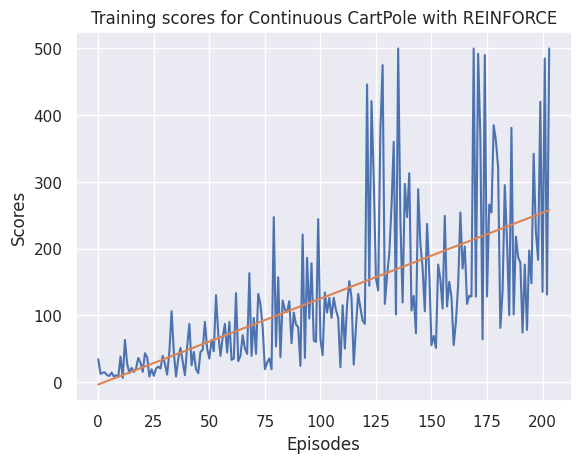

In [8]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import seaborn as sns
import numpy as np

sns.set()

graphed_array = scores

plt.plot(graphed_array)
plt.ylabel('Scores')
plt.xlabel('Episodes')
plt.title('Training scores for Continuous CartPole with REINFORCE')
plt.axis((None,None,None,None))

reg = LinearRegression().fit(np.arange(len(graphed_array)).reshape(-1, 1), np.array(graphed_array).reshape(-1, 1))
y_pred = reg.predict(np.arange(len(graphed_array)).reshape(-1, 1))
plt.plot(y_pred)
plt.show()

#### Random Policy:

In [9]:
done = False
state = env.reset()
scores = []

for _ in tqdm(range(50)):
    state = env.reset()
    done = False
    score = 0
    while not done:
        env.render()
        action = env.action_space.sample()
        new_state, reward, done, info = env.step(action)
        score += reward
        state = new_state
    scores.append(score)
env.close()

  0%|          | 0/50 [00:00<?, ?it/s]/home/a.shankar/Documents/Work/ContinuousRL/.env/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:317: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(
  0%|          | 0/50 [00:00<?, ?it/s]


ImportError: cannot import name 'rendering' from 'gym.envs.classic_control' (/home/a.shankar/Documents/Work/ContinuousRL/.env/lib/python3.10/site-packages/gym/envs/classic_control/__init__.py)

#### Trying Policy:

In [27]:
done = False
state = env.reset()
scores = []

for _ in tqdm_notebook(range(50)):
    state = env.reset()
    done = False
    score = 0
    for step in range(MAX_STEPS):
        #env.render()
        action, la, mu, sigma = select_action(network, state)
        new_state, reward, done, info = env.step(action)
        score += reward
        state = new_state
        
        if done:
            break
    scores.append(score)
env.close()

In [28]:
np.array(scores).mean()

381.8

In [13]:
env.close()